# Simulate latent dynamics

In [3]:
import numpy as np

In [4]:
def RelU(x):
    return np.maximum(0,x)


def simulate_latent(T, A, W, h, z0, noise_std= 0.1 ): #for all time steps
    M = A.shape[0] #A is linear transition matrix
    z = np.zeros((T,M))
    z[0] = z0
    for i in range(1, T):
        #equation 1
        term1 = np.matmul(A,z[i-1])
        term2 = np.matmul(W, RelU(z[i-1]))

        #It is an autonomous RNN. there are no inputs
        z[i] = term1 + term2 + h + np.random.normal(0, noise_std, size = M)

    return z

#I noticed  an issue  where the latent variables blew up. This is because 
# the spectral radius is not controlle for like  in reservoir computing. 
# since both A and W are with zt both A and W contribute to zt blowing up
# W only contribute to the blowing up of active zts so we need to mask the 
# columns to  be more accruate like done in e step. for now its a rough
# scaling where we assume all W is active. if we assume the relu is always 
# active zt = (A + W) zprev and we can compute the spectral radius of this

def scale_plrnn_dynamics(A, W, target_rho=0.95):
    combined = A + W  # effective matrix assuming ReLU is active
    eigvals = np.linalg.eigvals(combined)
    spectral_radius = np.max(np.abs(eigvals))
    
    scaling = target_rho / spectral_radius
    
    A_scaled = A * scaling
    W_scaled = W * scaling
    
    return A_scaled, W_scaled


In [5]:
M = 3  
T = 100
A = np.eye(M) * 0.9  # Slight decay
W = np.random.randn(M, M) * 0.5  # Random weights
A, W = scale_plrnn_dynamics(A, W, target_rho=0.9) #keep in mind this is scaled A and W
#im assuming its okay for now as W is random anyways 
h = np.zeros(M)  # Zero for now
z0 = np.random.randn(M)  # Initial condition
noise_std = 0.05

latent_traj = simulate_latent(T, A, W, h, z0, noise_std)


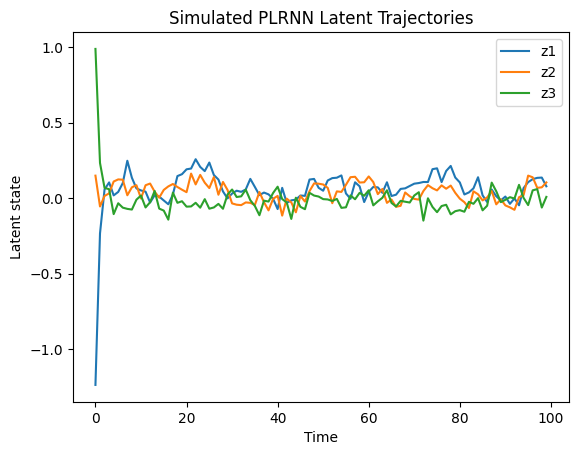

In [6]:
import matplotlib.pyplot as plt

for i in range(M):
    plt.plot(latent_traj[:, i], label=f'z{i+1}')
plt.xlabel('Time')
plt.ylabel('Latent state')
plt.legend()
plt.title('Simulated PLRNN Latent Trajectories')
plt.show()



# Simulate observables

simulate xt using the observation model defined in the paper. We are using the  linear-Gaussian model, eqn 2.

In [7]:
latent_traj.shape[0]

100

In [8]:
def simulate_obs(latent_traj,B,N, cov = 0.1): #B should have shape N by M, for N dimensional observation
    T = latent_traj.shape[0] # time of simulation
    M = latent_traj.shape[1] #size of vector 
    obs = np.zeros((T,N))
    for t in range(0, T):
        noise = np.random.normal(0, cov, size = N)
        
        obs[t] = np.matmul(B, RelU(latent_traj[t])) + noise

    return obs

In [9]:
M = 2 
T = 100
A = np.eye(M) * 0.9  # Slight decay
W = np.random.randn(M, M) * 0.5  # Random weights
A, W = scale_plrnn_dynamics(A, W, target_rho=0.9) #keep in mind this is scaled A and W
#im assuming its okay for now as W is random anyways 
h = np.zeros(M)  # Zero for now
z0 = np.random.randn(M)  # Initial condition
# should be mu0 + Cs1, Sigma as defined in eqn 1
noise_std = 0.05

latent_traj = simulate_latent(T, A, W, h, z0, noise_std)

N = 10
B = np.random.randn(N,M)
observations = simulate_obs(latent_traj,B,N, cov = 0.05)

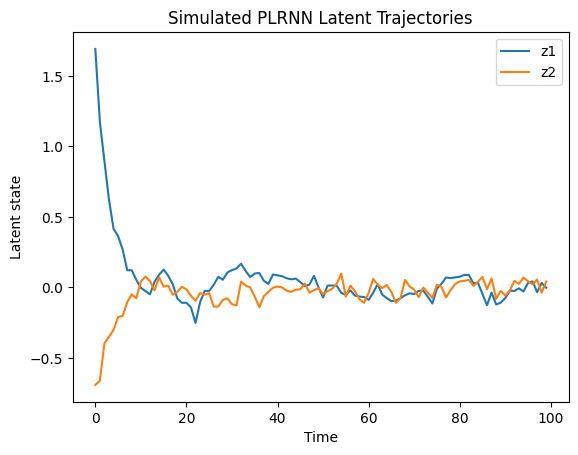

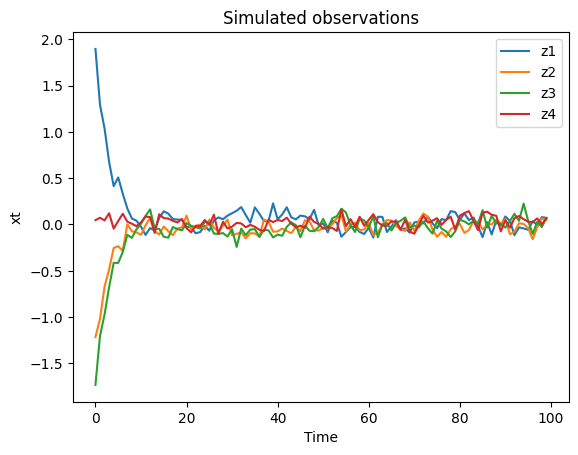

In [10]:
for i in range(2):
    plt.plot(latent_traj[:, i], label=f'z{i+1}')
plt.xlabel('Time')
plt.ylabel('Latent state')
plt.legend()
plt.title('Simulated PLRNN Latent Trajectories')
plt.show()

for i in range(4):
    plt.plot(observations[:, i], label=f'z{i+1}')
plt.xlabel('Time')
plt.ylabel('xt')
plt.legend()
plt.title('Simulated observations')
plt.show()

In [11]:
import numpy as np

class PLRNN:
    def __init__(self, dim, A=None, W=None, h=None, noise_std=0.05, target_rho=0.9, scale=True):
        """
        Initialize PLRNN simulator.
        
        Args:
            dim (int): Dimension of latent state z.
            A, W (np.ndarray): Optional initial matrices (shape [dim, dim]).
            h (np.ndarray): Optional bias vector.
            noise_std (float): Standard deviation of Gaussian process noise.
            target_rho (float): Desired spectral radius (if scaling is enabled).
            scale (bool): Whether to scale A and W to control spectral radius.
        """
        self.dim = dim
        self.A = A if A is not None else np.random.randn(dim, dim)
        self.W = W if W is not None else np.random.randn(dim, dim)
        self.h = h if h is not None else np.zeros(dim)
        self.noise_std = noise_std
        
        if scale:
            self.scale_dynamics(target_rho)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def scale_dynamics(self, target_rho):
        """
        Scale A and W so the spectral radius of (A + W) is at most target_rho.
        """
        J = self.A + self.W
        eigvals = np.linalg.eigvals(J)
        spectral_radius = np.max(np.abs(eigvals))
        if spectral_radius == 0:
            scaling = 1.0
        else:
            scaling = target_rho / spectral_radius
        
        self.A *= scaling
        self.W *= scaling
        print(f"Scaled A and W to spectral radius ≈ {target_rho:.3f}")

    def simulate(self, z0, T, return_radii=False):
        """
        Simulate latent trajectory for T time steps from initial state z0.

        Args:
            z0 (np.ndarray): Initial latent state (shape: [dim]).
            T (int): Number of time steps.
            return_radii (bool): If True, also return spectral radius per step.
        
        Returns:
            z (np.ndarray): Simulated latent trajectory of shape [T, dim].
            (optional) spectral_radii (list of float): Radius at each step.
        """
        z = np.zeros((T, self.dim))
        z[0] = z0
        spectral_radii = []

        for t in range(1, T):
            relu_z = self.relu(z[t-1])
            noise = np.random.normal(0, self.noise_std, size=self.dim)
            z[t] = self.A @ z[t-1] + self.W @ relu_z + self.h + noise

            if return_radii:
                active = z[t-1] > 0
                W_eff = self.W.copy()
                W_eff[:, ~active] = 0
                J = self.A + W_eff
                sr = np.max(np.abs(np.linalg.eigvals(J)))
                spectral_radii.append(sr)

        return (z, spectral_radii) if return_radii else z
class PLRNN:
    def __init__(self, dim, A=None, W=None, h=None, noise_std=0.05, target_rho=0.9, scale=True):
        self.dim = dim  # dimension of latent state z
        self.A = A if A is not None else np.random.randn(dim, dim)
        self.W = W if W is not None else np.random.randn(dim, dim)
        self.h = h if h is not None else np.zeros(dim)
        self.noise_std = noise_std
        
        if scale:
            self.scale_dynamics(target_rho)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def scale_dynamics(self, target_rho):
        J = self.A + self.W
        eigvals = np.linalg.eigvals(J)
        spectral_radius = np.max(np.abs(eigvals))
        if spectral_radius == 0:
            scaling = 1.0
        else:
            scaling = target_rho / spectral_radius
        
        self.A *= scaling
        self.W *= scaling
        print(f"Scaled A and W to spectral radius ≈ {target_rho:.3f}")

    def simulate(self, z0, T, return_radii=False):
        z = np.zeros((T, self.dim))
        z[0] = z0
        spectral_radii = []

        for t in range(1, T):
            relu_z = self.relu(z[t-1])
            noise = np.random.normal(0, self.noise_std, size=self.dim)
            z[t] = self.A @ z[t-1] + self.W @ relu_z + self.h + noise

            if return_radii:
                active = z[t-1] > 0
                W_eff = self.W.copy()
                W_eff[:, ~active] = 0
                J = self.A + W_eff
                sr = np.max(np.abs(np.linalg.eigvals(J)))
                spectral_radii.append(sr)

        return (z, spectral_radii) if return_radii else z

    def simulate_observations(self, latent_traj, B, noise_std_obs=0.1):
        """
        Simulate linear Gaussian observations: x_t = B · ReLU(z_t) + noise

        Args:
            latent_traj (np.ndarray): Latent state trajectory of shape [T, dim]
            B (np.ndarray): Observation matrix of shape [N, dim]
            noise_std_obs (float): Observation noise standard deviation

        Returns:
            obs (np.ndarray): Observed data of shape [T, N]
        """
        T = latent_traj.shape[0]
        N = B.shape[0]
        obs = np.zeros((T, N))

        for t in range(T):
            relu_z = self.relu(latent_traj[t])
            noise = np.random.normal(0, noise_std_obs, size=N)
            obs[t] = B @ relu_z + noise

        return obs


Scaled A and W to spectral radius ≈ 0.950


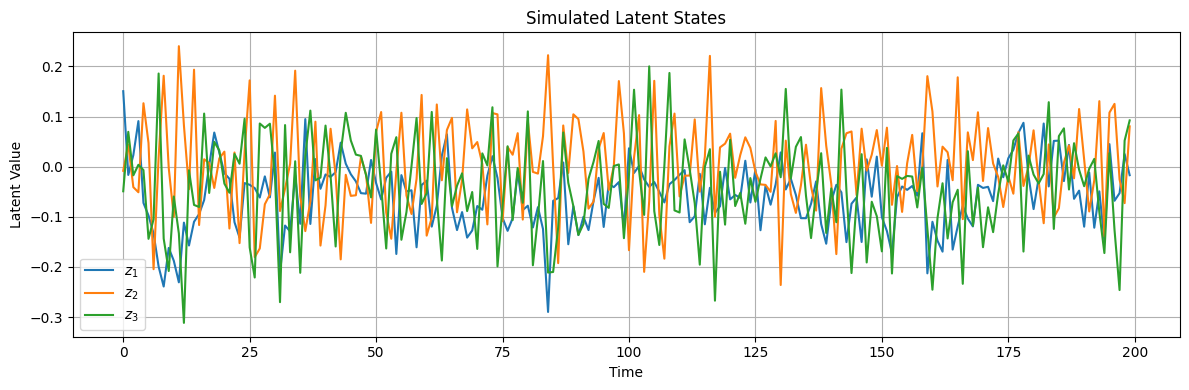

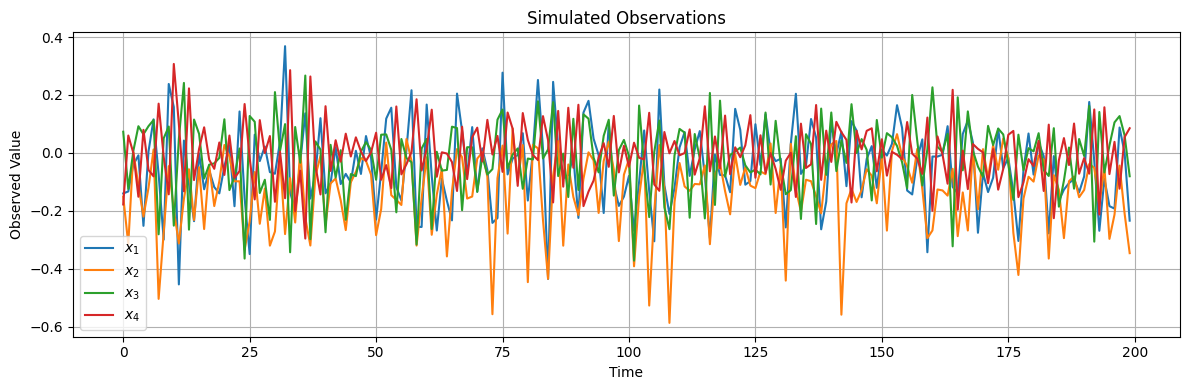

In [12]:
# Initialize model
dim_latent = 5
dim_obs = 10
T = 200

plrnn = PLRNN(dim=dim_latent, noise_std=0.05, target_rho=0.95)
z0 = np.random.randn(dim_latent) * 0.1

# Simulate latent trajectory
latent_traj = plrnn.simulate(z0, T)

# Create random observation matrix B
B = np.random.randn(dim_obs, dim_latent)

# Simulate observations
observations = plrnn.simulate_observations(latent_traj, B, noise_std_obs=0.05)

# Plot latent states
plt.figure(figsize=(12, 4))
for i in range(min(3, dim_latent)):
    plt.plot(latent_traj[:, i], label=f'$z_{i+1}$')
plt.title("Simulated Latent States")
plt.xlabel("Time")
plt.ylabel("Latent Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot observed states
plt.figure(figsize=(12, 4))
for i in range(min(4, dim_obs)):
    plt.plot(observations[:, i], label=f'$x_{i+1}$')
plt.title("Simulated Observations")
plt.xlabel("Time")
plt.ylabel("Observed Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

